(49961, 40, 16)
(49961, 51)
cuda
Epoch: 0100 cost = 0.018887
Epoch: 0100 accuracy = 0.018406
Epoch: 0200 cost = 0.018873
Epoch: 0200 accuracy = 0.018384
Epoch: 0300 cost = 0.018869
Epoch: 0300 accuracy = 0.018384
Epoch: 0400 cost = 0.018865
Epoch: 0400 accuracy = 0.018386
Epoch: 0500 cost = 0.018862
Epoch: 0500 accuracy = 0.018384
Epoch: 0600 cost = 0.018857
Epoch: 0600 accuracy = 0.018381
Epoch: 0700 cost = 0.018847
Epoch: 0700 accuracy = 0.018376
Epoch: 0800 cost = 0.018840
Epoch: 0800 accuracy = 0.018382
Epoch: 0900 cost = 0.018818
Epoch: 0900 accuracy = 0.018372
Epoch: 1000 cost = 0.018813
Epoch: 1000 accuracy = 0.018373


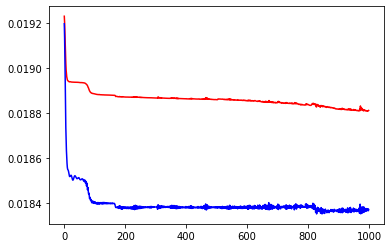

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F

#data_load
#(9961, 40, 16)
#(9961, 51)
train_lstm = np.load('/content/drive/MyDrive/BIG DATA/train_lstm.npy')
print(train_lstm.shape)
TF_lstm = np.load('/content/drive/MyDrive/BIG DATA/TF_lstm.npy')
print(TF_lstm.shape)
TFw = np.load('/content/drive/MyDrive/BIG DATA/TFw.npy')

gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)
train1 = torch.FloatTensor(train_lstm)
train = train1[0:20000,:,:].to(gpu)
trainv = train1[20000:30000,:,:].to(gpu)
TF1 = torch.FloatTensor(TF_lstm)
TF = TF1[0:20000,:].to(gpu)
TFv = TF1[20000:30000,:].to(gpu)
TFw1 = torch.FloatTensor(TFw)
TFw = TFw1[0:40000,:]
TFwv = TFw1[40000:,:]


#model sequence
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.softmax = nn.Softmax(dim=-1)
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input.to(gpu)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        softmax = self.softmax(rnn_output)
        return softmax


      


model = SingleRNN(input_size=16,hidden_size = 51, dropout = 0, bidirectional= False).to(gpu)
output1 = model(train)
# modelv = SingleRNN(input_size=16,hidden_size = 51, dropout = 0, bidirectional= False)

optimizer = optim.Adam(model.parameters(), lr=0.01)
best_model_wts = model.state_dict()
best_acc = 0
best_epoch = 0
criterion = nn.MSELoss()
l_array = []
a_array = []
for epoch in range(1000):
  for i in range(2):
    if i == 0:
      output = model(train)
      # loss = (torch.abs((output - TF))).mean()
      loss = criterion(output, TF)
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass
    
    if i == 1:
      pred = model(trainv)
      accuracy = criterion(pred,TFv)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if accuracy > best_acc:
        best_model_wts = model.state_dict()
        best_ephoch = epoch
      if (epoch+1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy))
    else:
      pass

plt.plot(l_array,'r')
plt.plot(a_array,'b')
plt.show()
model_save_name = 'classifierL.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(best_model_wts, path)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.softmax = nn.Softmax(dim=-1)
        

    def forward(self, input):
        # input shape: batch, seq, dim
        output = input.to(gpu)
        output = torch.unsqueeze(output,dim=0)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        softmax = self.softmax(rnn_output)
        return softmax
train_lstm = np.load('/content/drive/MyDrive/BIG DATA/train_lstm.npy')
print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/classifierL.pt'
model = SingleRNN(input_size=16,hidden_size = 51, dropout = 0, bidirectional= False).to(gpu)
model.load_state_dict(torch.load(model_wts))
train1 = torch.FloatTensor(train_lstm).to(gpu)
target = model(train1[0,:,:])
print(target)

cuda
(49961, 40, 16)
tensor([[0.1008, 0.0136, 0.0136, 0.0136, 0.0136, 0.0136, 0.0136, 0.0136, 0.0136,
         0.0136, 0.0136, 0.0136, 0.0136, 0.0136, 0.0138, 0.0138, 0.0165, 0.0170,
         0.0151, 0.0143, 0.0254, 0.0147, 0.0181, 0.0138, 0.0368, 0.0144, 0.0174,
         0.0197, 0.0179, 0.0156, 0.0138, 0.0371, 0.0371, 0.0145, 0.0255, 0.0139,
         0.0136, 0.0137, 0.0169, 0.0139, 0.0136, 0.0136, 0.0137, 0.0137, 0.0136,
         0.0136, 0.0136, 0.0136, 0.0136, 0.0136, 0.1008]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
